In [ ]:
# This cell is used for creating a button that hides/unhides code cells to quickly look only the results.
# Works only with Jupyter Notebooks.

from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
# Description:
#   Exercise4 notebook.
#
# Copyright (C) 2018 Santiago Cortes, Juha Ylioinas
#
# This software is distributed under the GNU General Public 
# Licence (version 2 or later); please refer to the file 
# Licence.txt, included with the software, for details.

# Preparations
import os
from PIL import Image
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import cv2
from itertools import compress

from scipy.ndimage import maximum_filter
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import convolve1d as conv1
from scipy.ndimage.filters import convolve as conv2

from skimage.io import imread
from skimage.transform import ProjectiveTransform, SimilarityTransform, AffineTransform
from skimage.measure import ransac

from utils import gaussian2, maxinterp, circle_points

import time

# Select data directory
if os.path.isdir('/coursedata'):
    # JupyterHub
    course_data_dir = '/coursedata'
elif os.path.isdir('../../../coursedata'):
    # Local installation
    course_data_dir = '../../../coursedata'
else:
    # Docker
    course_data_dir = '/home/jovyan/work/coursedata/'

print('The data directory is %s' % course_data_dir)
data_dir = os.path.join(course_data_dir, 'exercise-04-data/')
print('Data stored in %s' % data_dir)

The data directory is /coursedata
Data stored in /coursedata/exercise-04-data/


# CS-E4850 Computer Vision Exercise Round 4
The problems should be solved before the exercise session and solutions returned via
MyCourses. Upload to MyCourses both: this Jupyter Notebook (.ipynb) file containing your solutions to the programming tasks and the exported pdf version of this Notebook file. If there are both programming and pen & paper tasks kindly combine the two pdf files (your scanned/LaTeX solutions and the exported Notebook) into a single pdf and submit that with the Notebook (.ipynb) file. <br><br> Note that (1) you are not supposed to change anything in the utils.py and (2) you should be sure that everything that you need to implement should work with the pictures specified by the assignments of this exercise round. 

<b>NOTE: In order to avoid errors caused by running the cells in mixed order (which quite often happens while trying different things and debugging), while working on a particular cell be sure that you have freshly run all its preceding cells belonging to the same exercise. <b>

Fill your name and student number below.

### Name:
### Student number:

## Exercise 1 - Matching Harris corner points
In this exercise, you will familiarize yourself with the method of Harris interest point detection. The aim is to first detect Harris corners from two images of the same scene. Then, image patches of size 15x15 pixels around each detected corner point is extracted following a matching step where mutually nearest neighbors are found using the sum of squared differences (SSD) similarity measure. <br><br>
The SSD measure for two image patches, $f$ and $g$, is defined as follows<br><br>

<center>$SSD(f,g) = \sum_{k,l}(g(k,l)-f(k,l))^{2}$</center> 
so that the larger the SSD value the more dissimilar the patches are.
<br><br>
Do the task (a) below and answer questions in (b):



In [ ]:
## The first part uses OpenCV computer vision library to
## extract Harris corner points
## (source: https://docs.opencv.org/3.0-beta/doc/py_tutorials/
## py_feature2d/py_features_harris/py_features_harris.html)
I1 = imread(data_dir+'Boston1.png');
R1 = cv2.cornerHarris(I1,2,3,0.04)

# Take only the local maxima of the corner response function
fp = np.ones((3,3))
fp[1,1] = 0
maxNR1 = maximum_filter(R1, footprint=fp, mode='constant')

# Test if cornerness is larger than neighborhood
cornerI1 = R1>maxNR1

# Threshold for low value maxima
maxCV1 = np.amax(R1)

# Find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8((R1>0.0001*maxCV1)*cornerI1))

# Define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(I1,np.float32(centroids),(5,5),(-1,-1), criteria)
kp1=corners.T

# Display Harris keypoints
plt.figure(figsize=(20,10))
plt.imshow(I1, cmap='gray')
plt.plot([kp1[0]],[kp1[1]],'rx')
plt.suptitle("Harris Corners using OpenCV", fontsize=20)
plt.show()

In [ ]:
## The previous part illustrated OpenCV's built-in capabilities.
## Let's try to do Harris corner extraction and matching using our own
## implementation in a less black-box manner.

## Familiarize yourself with the harris function
def harris(im, sigma=1.0, relTh=0.0001, k=0.04):
    im = im.astype(np.float) # Make sure im is float
    
    # Get smoothing and derivative filters
    g, _, _, _, _, _, = gaussian2(sigma)
    _, gx, gy, _, _, _, = gaussian2(np.sqrt(0.5))
    
    # Partial derivatives
    Ix = conv2(im, -gx, mode='constant')
    Iy = conv2(im, -gy, mode='constant')
    
    # Components of the second moment matrix
    Ix2Sm = conv2(Ix**2, g, mode='constant')
    Iy2Sm = conv2(Iy**2, g, mode='constant')
    IxIySm = conv2(Ix*Iy, g, mode='constant')
    
    # Determinant and trace for calculating the corner response
    detC = (Ix2Sm*Iy2Sm)-(IxIySm**2)
    traceC = Ix2Sm+Iy2Sm
    
    # Corner response function R
    # "Corner": R > 0
    # "Edge": R < 0
    # "Flat": |R| = small
    R = detC-k*traceC**2
    maxCornerValue = np.amax(R)
    
    # Take only the local maxima of the corner response function
    fp = np.ones((3,3))
    fp[1,1] = 0
    maxImg = maximum_filter(R, footprint=fp, mode='constant')
    
    # Test if cornerness is larger than neighborhood
    cornerImg = R>maxImg
    
    # Threshold for low value maxima
    y, x = np.nonzero((R>relTh*maxCornerValue)*cornerImg) 
    
    # Convert to float
    x = x.astype(np.float)
    y = y.astype(np.float)
    
    # Remove responses from image borders to reduce false corner detections
    r, c = R.shape
    idx = np.nonzero((x<2)+(x>c-3)+(y<2)+(y>r-3))[0]
    x = np.delete(x,idx)
    y = np.delete(y,idx)
    
    # Parabolic interpolation
    for i in range(len(x)):
        _,dx=maxinterp((R[int(y[i]), int(x[i])-1], R[int(y[i]), int(x[i])], R[int(y[i]), int(x[i])+1]))
        _,dy=maxinterp((R[int(y[i])-1, int(x[i])], R[int(y[i]), int(x[i])], R[int(y[i])+1, int(x[i])]))
        x[i]=x[i]+dx
        y[i]=y[i]+dy
        
    return x, y, cornerImg

In [ ]:
# Load images
I1 = imread(data_dir+'Boston1.png')/255.
I2 = imread(data_dir+'Boston2m.png')/255.

# Harris corner extraction, take a look at the source code above
x1, y1, cimg1 = harris(I1)
x2, y2, cimg2 = harris(I2)

## We pre-allocate the memory for the 15*15 image patches extracted
## around each corner point from both images
patch_size=15
npts1=x1.shape[0]
npts2=x2.shape[0]
patches1=np.zeros((patch_size, patch_size, npts1))
patches2=np.zeros((patch_size, patch_size, npts2))

## The following part extracts the patches using bilinear interpolation
k=(patch_size-1)/2.
xv,yv=np.meshgrid(np.arange(-k,k+1),np.arange(-k, k+1))
for i in range(npts1):
    patch = map_coordinates(I1, (yv + y1[i], xv + x1[i]))
    patches1[:,:,i] = patch
for i in range(npts2):
    patch = map_coordinates(I2, (yv + y2[i], xv + x2[i]))
    patches2[:,:,i] = patch

## We compute the sum of squared differences (SSD) of pixels' intensities
## for all pairs of patches extracted from the two images
distmat = np.zeros((npts1, npts2))
for i1 in range(npts1):
    for i2 in range(npts2):
        distmat[i1,i2]=np.sum((patches1[:,:,i1]-patches2[:,:,i2])**2)

## Next we compute pairs of patches that are mutually nearest neighbors
## according to the SSD measure
ss1 = np.amin(distmat, axis=1)
ids1 = np.argmin(distmat, axis=1)
ss2 = np.amin(distmat, axis=0)
ids2 = np.argmin(distmat, axis=0)

pairs = []
for k in range(npts1):
    if k == ids2[ids1[k]]:
        pairs.append(np.array([k, ids1[k], ss1[k]]))
pairs = np.array(pairs)

## We sort the mutually nearest neighbors based on the SSD
sorted_ssd = np.sort(pairs[:,2], axis=0)
id_ssd = np.argsort(pairs[:,2], axis=0)

## Estimate the geometric transformation between images
src=[]
dst=[]
for k in range(len(id_ssd)):
    l = id_ssd[k]
    src.append([x1[int(pairs[l, 0])], y1[int(pairs[l, 0])]])
    dst.append([x2[int(pairs[l, 1])], y2[int(pairs[l, 1])]])
src=np.array(src)
dst=np.array(dst)
rthrs=2
tform,_ = ransac((src, dst), ProjectiveTransform, min_samples=4,
                               residual_threshold=rthrs, max_trials=1000)
H1to2p = tform.params

## Next we visualize the 40 best matches which are mutual nearest neighbors
## and have the smallest SSD values
Nvis = 40
montage = np.concatenate((I1, I2), axis=1)

plt.figure(figsize=(16, 8))
plt.suptitle("The best 40 matches according to SSD measure", fontsize=20)
plt.imshow(montage, cmap='gray')
plt.title('The best 40 matches')
for k in range(np.minimum(len(id_ssd), Nvis)):
    l = id_ssd[k]
    plt.plot(x1[int(pairs[l, 0])], y1[int(pairs[l, 0])], 'rx')
    plt.plot(x2[int(pairs[l, 1])] + I1.shape[1], y2[int(pairs[l, 1])], 'rx')
    plt.plot([x1[int(pairs[l, 0])], x2[int(pairs[l, 1])]+I1.shape[1]], 
         [y1[int(pairs[l, 0])], y2[int(pairs[l, 1])]])

## Finally, since we have estimated the planar projective transformation
## we can check that how many of the nearest neighbor matches actually
## are correct correspondences
p1to2=np.dot(H1to2p, np.hstack((src, np.ones((src.shape[0],1)))).T)
p1to2 = p1to2[:2,:] / p1to2[2,:]
p1to2 = p1to2.T
pdiff=np.sqrt(np.sum((dst-p1to2)**2, axis=1))

# The criterion for the match being a correct is that its correspondence in
# the second image should be at most rthrs=2 pixels away from the transformed
# location
n_correct = len(pdiff[pdiff<rthrs])
print("{} correct matches.".format(n_correct))

### a) Matching points using normalized cross-correlation (NCC)
Implement the matching of mutually nearest neighbors using normalized cross-correlation
(NCC) as the similarity measure instead of SSD. <br><br>

For two image patches of similar size it can be written as follows (also given in the slide 97 of
Lecture 2):
<br><br>
<center>$NCC(f,g) = \frac{\sum_{k,l}(g(k,l)-\bar{g})(f(k,l)-\bar{f})}{\sqrt{\sum_{k,l}(g(k,l)-\bar{g})^{2}\sum_{k,l}(f(k,l)-\bar{f})^{2}}}$</center> <br><br>
where $\bar{g}$ and $\bar{f}$ are the mean intensity values of patches $g$ and $f$. The values of NCC are
always between -1 and 1, and the larger the value the more similar the patches are.

In [ ]:
## Now, your task is to do matching in similar manner but using normalised 
## cross-correlation (NCC) instead of SSD. You should also report the 
## number of correct correspondences for NCC as shown above for SSD.
##
## HINT: Compared to the previous SDD-based implementation, all you need 
## to do is to modify the lines performing the 'distmat' calculation
## from SSD to NCC.
## Thereafter, you can proceed as above but notice the following details:
## You need to determine the mutually nearest neighbors by
## finding pairs for which NCC is maximized (i.e. not minimized like SSD).
## Also, you need to sort the matches in descending order in terms of NCC
## in order to find the best matches (i.e. not ascending order as with SSD). 

# Measure pairwise distances NCC
##-your-code-starts-here-##




##-your-code-ends-here-##

### b) Answer the questions below
1) How  many  correct  correspondences  do  you  get  by  using  NCC  instead  of  SSD?
<br>
2) Which  one  of  the  two  similarity  measures  performs  better  in  this  case  and  why? <br>

Type your answers here:

## Exercise 2 - Matching SURF regions
SURF (Speeded up robust features) is quite similar to SIFT which was presented in Lecture 3. In this implementation the descriptor vectors for the local regions have 64 elements (instead of 128 in SIFT) but
Euclidean distance can still be used as a similarity measure in descriptor space. See the
comments in the source code and do the following tasks:<br><br>
a) Sort the given nearest neighbor matches in ascending order based on the nearest
neighbor distance ratio (NNDR), which is defined in Equation (4.18) in the course book.
Report the number of correct correspondences among the top 5 matches based on NNDR
and compare it to the case where ordering is based on nearest neighbor distance.<br>
b) Answer some questions (see them below... )

In [ ]:
## The first part uses OpenCV computer vision and scikit's image processing
## libraries.
## SURF regions are extracted and matched and a similarity transformation 
## (i.e. rotation, translation and scale) between the views is estimated
img1 = np.array(Image.open(data_dir+'boat1.png'))
img2 = np.array(Image.open(data_dir+'boat6.png'))

# Initiate SURF detector
surf = cv2.xfeatures2d.SURF_create()
# Find the keypoints and descriptors with SIFT detector
kp1, desc1 = surf.detectAndCompute(img1, None)
kp2, desc2 = surf.detectAndCompute(img2, None)
kps1 = np.array([p.pt for p in kp1])
kps2 = np.array([p.pt for p in kp2])
kps1_rad = np.array([p.size / 2 for p in kp1]) #rad==scale
kps2_rad = np.array([p.size / 2 for p in kp2])

## Sift should work this year -> Code below should not be needed.
## ------------------------------------------------------------------------------------------
## You may use the lines below if you do not have opencv compiled with opencv-contrib 
## (surf and sift are only part of that as they are patented)

## Precomputed features and descriptors

## Using a trick to circumvent a bug in the new version of np.load
## save np.load
#np_load_old = np.load

# modify the default parameters of np.load
#np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
#data1=np.load(data_dir+"img1_surf_kps_descs.npy", encoding='latin1')
#data2=np.load(data_dir+"img2_surf_kps_descs.npy", encoding='latin1')

## restore np.load for future normal usage
#np.load = np_load_old

#kps1 = data1.item().get('keypoints')
#kps1_rad = data1.item().get('keypoint_rads')
#desc1 = data1.item().get('descriptors')

#kps2 = data2.item().get('keypoints')
#kps2_rad = data2.item().get('keypoint_rads')
#desc2 = data2.item().get('descriptors')

#kp1 = []
#kp2 = []
#for i in range(kps1.shape[0]):
#    p=cv2.KeyPoint()
#    p.pt = (kps1[i,0], kps1[i,1]) # coordinates of the keaypoints
#    p.size = kps1_rad[i] * 2 # diameter of the blob feature
#    kp1.append(p)
    
#for i in range(kps2.shape[0]):
#    p=cv2.KeyPoint()
#    p.pt = (kps2[i,0], kps2[i,1])
#    p.size = kps2_rad[i] * 2
#    kp2.append(p)
## ------------------------------------------------------------------------------------------

# Initiate BruteForce matcher with default params
bf = cv2.BFMatcher()
# Perform matching and save k=1 nearest neighbors for each descriptor
matches = bf.knnMatch(desc1, desc2, k=1)
# The candidate point matches can be visualized as follows:
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,flags=2)
plt.figure(figsize=(16,8))
plt.suptitle('Feature matching using SURF regions', fontsize=20)
plt.imshow(img3)
plt.title('Candidate point matches')
plt.show()

## The estimation of geometric transformations is covered later in lectures
## but it can be done as follows using scikit-image Python library:
# Collect feature points and scales from the match objects
source_pts = []
target_pts = []

for match in matches:
    # Collect feature point coords and scale query (img1)
    x, y = kp1[match[0].queryIdx].pt 
    source_pts.append(np.array([x, y]))  
    # Collect feature point coords and scale query (img2)
    x, y = kp2[match[0].trainIdx].pt
    target_pts.append(np.array([x, y]))
    
source_pts = np.array(source_pts)
target_pts = np.array(target_pts)

## Estimate the geometric transformation between images
rthrs=10
tform, inliers = ransac((source_pts, target_pts), SimilarityTransform, min_samples=2,
                               residual_threshold=rthrs, max_trials=1000)
H1to2p = tform.params

s_in = source_pts[inliers,:]
t_in = target_pts[inliers,:]

source_pts_aug = np.hstack((s_in,np.ones((s_in.shape[0],1))))
target_pts_aug = np.hstack((t_in,np.ones((t_in.shape[0],1))))

target_ = np.dot(H1to2p,source_pts_aug.T)
target_ = target_[:2,:] / target_[2,:]
target_ = target_.T

xv, yv = np.meshgrid(np.arange(0,img1.shape[1]), np.arange(0,img1.shape[0]))
src_all = np.vstack((xv.flatten(), yv.flatten(), np.ones((1, xv.size))))
target_all = np.dot(H1to2p, src_all)
target_all_ = target_all[:2,:] / target_all[2,:]
xvt = target_all_[0,:].reshape(xv.shape[0], xv.shape[1])
yvt = target_all_[1,:].reshape(yv.shape[0], yv.shape[1])
img2t = map_coordinates(img2, (yvt, xvt))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,8))
ax = axes.ravel()
ax[0].imshow(img1, cmap='gray')
ax[0].set_title("Input Image 1")
ax[1].imshow(img2t, cmap='gray')
ax[1].set_title("Transformed Image 2")
ax[2].imshow(np.abs(img1-img2t), cmap='gray')
ax[2].set_title("Difference image after geometric registration")

matches_in = list(compress(matches, inliers))
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches_in,None,flags=2)
plt.figure(figsize=(16,8))
plt.imshow(img3)
plt.title("Matched inlier points")
plt.show()

In [ ]:
## The previous part illustrated OpenCV's built-in brute force matcher.
## Let's do the nearest neighbor matching for feature vectors in desc1 and desc2
## by using our own implementation.

## We compute the pairwise distances of feature vectors to matrix 'distmat'
## you can use the for-loop version or faster vectorized version
#distmat = np.zeros((desc1.shape[0], desc2.shape[0]))
#for i in range(desc1.shape[0]):
#    for j in range(desc2.shape[0]):
#        distmat[i,j] = np.linalg.norm(desc1[i,:] - desc2[j,:])
## Vectorized version: sqrt(xTx + yTy - 2xTy)
distmat = np.dot(desc1, desc2.T)
X_terms = np.expand_dims(np.diag(np.dot(desc1, desc1.T)), axis=1)
X_terms = np.tile(X_terms,(1,desc2.shape[0]))
Y_terms = np.expand_dims(np.diag(np.dot(desc2, desc2.T)), axis=0)
Y_terms = np.tile(Y_terms,(desc1.shape[0],1))
distmat = np.sqrt(Y_terms + X_terms - 2*distmat)

## We determine the mutually nearest neighbors
dist1 = np.amin(distmat, axis=1)
ids1 = np.argmin(distmat, axis=1)
dist2 = np.amin(distmat, axis=0)
ids2 = np.argmin(distmat, axis=0)

pairs = []
for k in range(ids1.size):
    if k == ids2[ids1[k]]:
        pairs.append(np.array([k, ids1[k], dist1[k]]))
pairs = np.array(pairs)

# We sort the mutually nearest neighbors based on the distance 
snnd = np.sort(pairs[:,2], axis=0)
id_nnd = np.argsort(pairs[:,2], axis=0)

# We visualize the 5 best matches 
Nvis = 5

plt.figure(figsize=(16, 8))
plt.suptitle("Top 5 mutual nearest neigbors of SURF features", fontsize=20)
plt.imshow(np.hstack((img1, img2)), cmap='gray')

t = np.arange(0, 2*np.pi, 0.1)

# Display matches
for k in range(Nvis):
    pid1 = pairs[id_nnd[k], 0]
    pid2 = pairs[id_nnd[k], 1]
    
    loc1 = kps1[int(pid1)]
    r1 = 6*kps1_rad[int(pid1)]
    loc2 = kps2[int(pid2)]
    r2 = 6*kps2_rad[int(pid2)]
    
    plt.plot(loc1[0]+r1*np.cos(t), loc1[1]+r1*np.sin(t), 'm-', linewidth=3)
    plt.plot(loc2[0]+r2*np.cos(t)+img1.shape[1], loc2[1]+r2*np.sin(t), 'm-', linewidth=3)
    plt.plot([loc1[0], loc2[0]+img1.shape[1]], [loc1[1], loc2[1]], 'c-')
    
# How many of the top 5 matches appear to be correct correspondences?

### a) Sorting matches according to the nearest neighbor distance ratio (NNDR)

In [ ]:
## Now, your task is to compute and visualize the top 5 matches based on 
## the nearest neighbor distance ratio defined in Equation (4.18) in the course book.
## How many of those are correct correspondences?

##-your-code-starts-here-##




##-your-code-ends-here-##

### b) Answer the questions below
1) What are the benefits of using SURF regions instead of Harris corners? 
<br>
2) Why the matching approach of Exercise 1 (i.e. Harris corners and NCC based matching) would not work for the example images of Exercise 2? 
<br>
3) In what kind of cases Harris corners may still be better than SURF and why?

Type your answers here:



## Exercise 3 - Scale-space blob detection

The python lines below illustrate pre-computed blob detections obtained with a similar procedure as implemented in SIFT and described below. Here the task is to replace the pre-computed regions with regions computed
by your own implementation. The result does not need to be exactly the same as the
pre-computed one but similar. In summary, implement the scale-space blob detector as
follows:
<br>a) Generate a Laplacian of Gaussian filter (you can set σ = 0.5).
<br>b) Build a Laplacian scale space, starting with some initial scale and going for n iterations:
- filter image with scale-normalized Laplacian at current scale
- save square of Laplacian response for current level of scale space
- increase scale by factor k

c) Perform non-maximum suppression in scale space.
<br>d) Display resulting circles at their characteristic scales.
<br><br>Apply the blob detector to example images boat1.png and boat6.png as shown in the
example script. Can you identify some corresponding regions?<br><br>
Note 1: Suitable values for k and n could be k = 1.19 and n = 18.<br>
Note 2: This task corresponds to Exercise 4.1 in the course book. A similar assignment
has been used by Lazebnik at UIUC and their course page gives also more detailed
instructions: http://slazebni.cs.illinois.edu/spring16/assignment2.html.

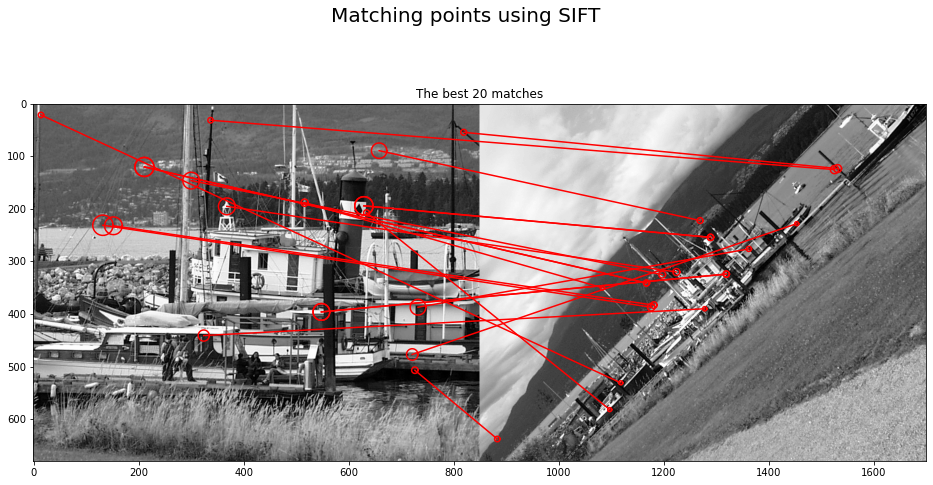

In [2]:
# Load images
img1 = np.array(Image.open(data_dir+'boat1.png'))
img2 = np.array(Image.open(data_dir+'boat6.png'))

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
# Find the keypoints and descriptors with SIFT detector
kp1, desc1 = sift.detectAndCompute(img1, None)
kp2, desc2 = sift.detectAndCompute(img2, None)

## Sift should work this year. -> Code below should not be needed.
## ------------------------------------------------------------------------------------------
## The same song here as in the previous exercise, no sift and surf if you dont compile
## with opencv-contrib, sorry. :L

## Using the same trick to circumvent a bug in the new version of np.load
## save np.load
#np_load_old = np.load

# modify the default parameters of np.load
#np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
#data1=np.load(data_dir+"boat1_sift_kps_descs.npy", encoding='latin1')
#data2=np.load(data_dir+"boat6_sift_kps_descs.npy", encoding='latin1')

## restore np.load for future normal usage
#np.load = np_load_old

#kps1 = data1.item().get('keypoints')
#kps1_rad = data1.item().get('keypoint_rads')
#desc1 = data1.item().get('descriptors')

#kps2 = data2.item().get('keypoints')
#kps2_rad = data2.item().get('keypoint_rads')
#desc2 = data2.item().get('descriptors')

#kp1 = []
#kp2 = []
#for i in range(kps1.shape[0]):
#    p=cv2.KeyPoint()
#    p.pt = (kps1[i,0], kps1[i,1])
#    p.size = kps1_rad[i] * 2
#    kp1.append(p)
    
#for i in range(kps2.shape[0]):
#    p=cv2.KeyPoint()
#    p.pt = (kps2[i,0], kps2[i,1])
#    p.size = kps2_rad[i] * 2
#    kp2.append(p)
## ------------------------------------------------------------------------------------------

# Initiate BruteForce matcher with default params
bf = cv2.BFMatcher()
# Perform matching and save k=2 nearest neighbors for each descriptor
matches = bf.knnMatch(desc1, desc2, k=2)
# Apply Lowe's ratio test
good_matches = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good_matches.append(m)
# Sort matches 
good_matches = sorted(good_matches, key = lambda x:x.distance)
# Collect feature points and scales from the match objects
source_pts = []
target_pts = []
source_radii = []
target_radii = []

for match in good_matches:
    # Collect feature point coords and scale query (img1)
    x, y = kp1[match.queryIdx].pt
    pt = np.array([np.round(x), np.round(y)]).astype(np.int)
    source_pts.append(pt)
    radius = kp1[match.queryIdx].size / 2.
    source_radii.append(radius)
    
    # Collect feature point coords and scale query (img2)
    x, y = kp2[match.trainIdx].pt
    pt = np.array([np.round(x), np.round(y)]).astype(np.int)
    target_pts.append(pt)
    radius = kp2[match.trainIdx].size / 2.
    target_radii.append(radius)
    
source_pts = np.array(source_pts)
source_radii = np.array(source_radii)
target_pts = np.array(target_pts)
target_radii = np.array(target_radii)

## Estimate the geometric transformation between images
rthrs=10
tform,_ = ransac((source_pts, target_pts), SimilarityTransform, min_samples=2,
                               residual_threshold=rthrs, max_trials=1000)
H1to2p = tform.params
s = np.sqrt(np.linalg.det(H1to2p[0:2,0:2]));
R = H1to2p[0:2,0:2] / s;
t = H1to2p[0:2,2];

# Plot 
montage = np.concatenate((img1, img2), axis=1)
Nvis = 20
plt.figure(figsize=(16, 8))
plt.suptitle("Matching points using SIFT", fontsize=20)
plt.imshow(montage, cmap='gray')
plt.title('The best {} matches'.format(Nvis))
for k in range(0, Nvis):   
    plt.plot([source_pts[k,0], target_pts[k,0]+img1.shape[1]],\
             [source_pts[k,1], target_pts[k,1]], 'r-')
    
    x,y=circle_points(source_pts[k,0], source_pts[k,1],\
                      3*np.sqrt(2)*source_radii[k])
    plt.plot(x, y, 'r', linewidth=1.5)
    
    x,y=circle_points(target_pts[k,0]+img1.shape[1], target_pts[k,1],\
                      3*np.sqrt(2)*target_radii[k])
    plt.plot(x, y, 'r', linewidth=1.5)


In [3]:
def scaleSpaceBlobs(img, N):
    start = time.time()
    
    sigma0 = 0.5      # The first sigma to start with
    k = 1.19          # 
    Nscales = 18      # Number of scales in scalespace (noticable effect on execution time, you can try different values)
    
    # Pre-allocate memory for the scale space, sigmas and filtered images
    scalespace = np.zeros((img.shape[0], img.shape[1], Nscales))
    sigmas = np.zeros(Nscales)
    tmpxx = np.zeros(img.shape)
    tmpyy = np.zeros(img.shape)
    
    # Create a scalespace by...
    print("Creating a scalespace...")
    for i in range(Nscales):
        # Get the current sigma and generate gaussian filters
        sigmas[i] = (k ** i) * sigma0
        g,_,_,gxx,gyy,_, = gaussian2(sigmas[i])

        # filter the image with the scale-normalized Laplacian of Gaussian
        # for each scale i and store the result to the variable scalespace[:,:,i]
        
        ##-your-code-starts-here-##
        tmpxx = conv2(img, gxx, mode='constant')
        tmpyy = conv2(img, gyy, mode='constant')        
        
        
        ##-your-code-ends-here-##
        scalespace[:,:,i] = (sigmas[i]**2 * (tmpxx + tmpyy))**2
        
    # Selection of local maxima, each maxima defines a circular region.
    
    print("Calculating local maxima...")
    # Pre-allocate memory for the local maxima images
    localmaxima = np.zeros(scalespace.shape)
    # Filter shape for calculating the local maxima
    footprint = np.ones((3,3))
    footprint[1,1] = 0
    for i in range(Nscales):
        # Calculate local maxima
        maxi = maximum_filter(scalespace[:,:,i], footprint=footprint, mode='constant')
        # test if pixel values are larger than neighborhood
        localmaxima[:,:,i] = scalespace[:,:,i] > maxi  
      
    # In the end each row in 'blobs' encodes one circular region as follows:.
    # [x, y, r, filter_response]
    # where x and y are the column and row coordinates of the circle center,
    # r is the radius of the circle, r=sqrt(2)*sigma (see slide 77 of Lecture 3)
    # last column indicates the response of the Laplacian of Gaussian filter
    blobs = None
    # Pre-allocate memory for consecutive scales
    scaleA = np.zeros(img.shape)
    scaleB = np.zeros(img.shape)
    scaleC = np.zeros(img.shape)
    
    print("Calculating detections...")
    for i in range(1,Nscales-1):
        # Consecutive scales
        scaleA = scalespace[:,:,i-1]
        scaleB = scalespace[:,:,i]
        scaleC = scalespace[:,:,i+1]
        # Indices of local maxima
        ri, ci = np.nonzero(localmaxima[:,:,i])        
        # Compare the current level to the previous and next level
        idmax = np.nonzero((scaleA[ri,ci] < scaleB[ri,ci]) * (scaleC[ri,ci] < scaleB[ri,ci]))[0]
        rlmax = ri[idmax]
        clmax = ci[idmax]
        # Add blob coordinates, circle radiuses and filter responses to 'blobs'
        if blobs is not None:
            tmp = np.vstack((clmax, rlmax, 
                      np.sqrt(2)*sigmas[i]*np.ones(len(rlmax)), 
                      scaleB[rlmax, clmax])).T
            blobs = np.vstack((blobs, tmp))
        else:
            blobs = np.vstack((clmax, rlmax, 
                      np.sqrt(2)*sigmas[i]*np.ones(len(rlmax)), 
                      scaleB[rlmax, clmax])).T

    # Sort the blobs according to the response of Laplacian of Gaussian.
    # Return N best detections.
    ids = np.argsort(blobs[:,3])
    sblobs = np.flipud(blobs[ids, :])
    blobsN = sblobs[0:min(N, sblobs.shape[0]), :]
    # Ouput the execution time
    print("Total time elapsed (s): " + str(time.time() - start) + "\n")

    return blobsN

Creating a scalespace...
Calculating local maxima...
Calculating detections...
Total time elapsed (s): 94.1070568561554

Creating a scalespace...
Calculating local maxima...
Calculating detections...
Total time elapsed (s): 92.41211271286011



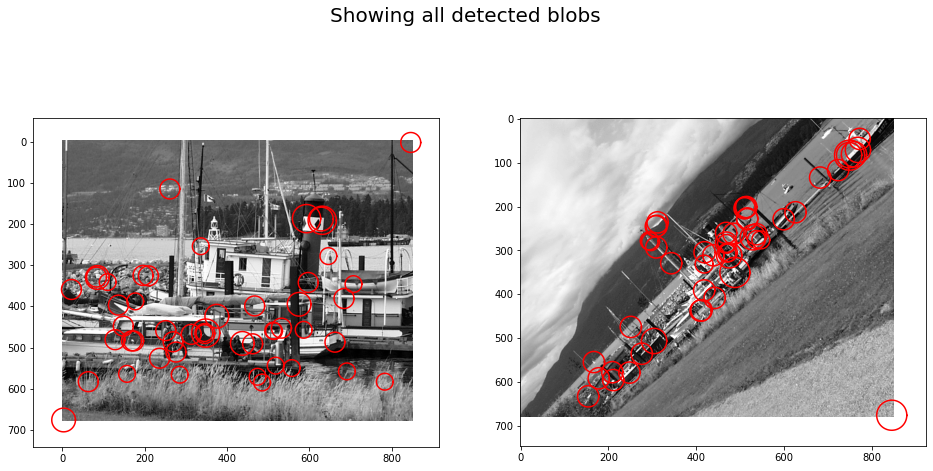

ValueError: shapes (2,2) and (500,2) not aligned: 2 (dim 1) != 500 (dim 0)

In [6]:
# The previous part illustrated OpenCV lib's built-in capabilities.

# Next, the task is to implement a similar blob detector as in SIFT. 
# In the example below the detections are pre-computed.
# Since we now know the true geometric transformation H1to2p we can 
# visualize those detections from both images which have large overlap.
# Your task is to implement the function scaleSpaceBlobs.m so that it
# outputs similar circular regions as pre-computed in 'blobs1' and 'blobs2'.

# Replace 'blobs1' and 'blobs2' below with the output of the detector.
data=np.load(data_dir+'blobs_data.npz', encoding='latin1')
blobs1=data['blobs1']
blobs2=data['blobs2']
# Each row in 'blobs1' and 'blobs2' defines a circular region as follows:  
# [x y r filter_response]
# here x and y are the column and row coordinates of the circle center
# r is the radius of the circle, r=sqrt(2)*sigma (see slide 77 of Lecture 3)
# last column indicates the response of the Laplacian of Gaussian filter

# Below N is the number of strongest blobs that are returned.
# (strongest local maxima for the scale-normalized Laplacian of Gaussian)
# Implement scaleSpaceBlobs.
# Everything should then work if you uncomment the following three lines and
# turn on your 

N=500;
blobs1 = scaleSpaceBlobs(img1, N)
blobs2 = scaleSpaceBlobs(img2, N)

# Show detected blob features
NVIS=50;
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
plt.suptitle("Showing all detected blobs", fontsize=20)
ax = axes.ravel()

ax[0].imshow(img1, cmap='gray')
ax[1].imshow(img2, cmap='gray')
for k in range(0, NVIS):
    x, y = circle_points(blobs1[k,0], blobs1[k,1], 3*np.sqrt(2)*blobs1[k,2])
    ax[0].plot(x, y, 'r', linewidth=1.5)
    x, y = circle_points(blobs2[k,0], blobs2[k,1], 3*np.sqrt(2)*blobs2[k,2])
    ax[1].plot(x, y, 'r', linewidth=1.5)
    
plt.show()

# below we illustrate detected regions with high overlap 
xy1to2=s*np.dot(R, blobs1[:,0:2].T)+np.tile(t,(blobs1.shape[0],1)).T
xy1to2=s*np.dot(R, blobs1[:,0:2].T)+np.tile(t,(blobs1.shape[0],1)).T

blobs1t=np.hstack((xy1to2.T, s*np.expand_dims(blobs1[:,2],axis=1), np.expand_dims(blobs1[:,3], axis=1)))

distmat = np.zeros((blobs1.shape[0], blobs2.shape[0]))
for i in range(blobs1.shape[0]):
    for j in range(blobs2.shape[0]):
        distmat[i,j] = np.linalg.norm(blobs1t[i, 0:3] - blobs2[j, 0:3])

dist = np.amin(distmat, axis=0)
nnids = np.argmin(distmat, axis=0)
sdist = np.sort(dist)
sids = np.argsort(dist)
idlist = np.vstack((nnids[sids], sids, sdist)).T

# Visualize the 20 best matches
Nvis = 10
plt.figure(figsize=(16,8))
plt.suptitle("Blob detection and matching", fontsize=20)

montage = np.concatenate((img1, img2), axis=1)
plt.imshow(montage, cmap='gray')
plt.title('Top {} nearest neighbors of blobs features'.format(Nvis))

t = np.arange(0, 2*np.pi+0.1, 0.1)
for k in range(Nvis):
    loc1 = blobs1[int(idlist[k, 0]), 0:2]
    r1 = 3*np.sqrt(2)*blobs1[int(idlist[k,0]), 2]
    loc2 = blobs2[int(idlist[k, 1]), 0:2]
    r2 = 3*np.sqrt(2)*blobs2[int(idlist[k,1]), 2]
    x1 = loc1[0]+r1*np.cos(t)
    y1 = loc1[1]+r1*np.sin(t)
    x2 = loc2[0]+r2*np.cos(t)+img1.shape[1]
    y2 = loc2[1]+r2*np.sin(t)
    plt.plot(x1, y1, 'm-', linewidth=3)
    plt.plot(x2, y2, 'm-', linewidth=3)
    plt.plot([loc1[0], loc2[0]+img1.shape[1]],[loc1[1], loc2[1]], 'c-')

In [ ]:
## This is just to convince you that the 
## vectorized descriptor matching implementation 
## illustrated above works correctly

X = np.random.randn(5, 10)
Y = np.random.randn(4, 10)

distmat = np.dot(X,Y.T)
X_terms = np.expand_dims(np.diag(np.dot(X, X.T)), axis=1)
X_terms = np.tile(X_terms,(1,4))
Y_terms = np.expand_dims(np.diag(np.dot(Y, Y.T)), axis=0)
Y_terms = np.tile(Y_terms,(5,1))
distmat = np.sqrt(Y_terms + X_terms - 2*distmat)

print(distmat)

distmat2 = np.zeros((X.shape[0], Y.shape[0]))
for i in range(X.shape[0]):
    for j in range(Y.shape[0]):
        distmat2[i,j] = np.linalg.norm(X[i,:] - Y[j,:])

print(distmat2)

print(np.sum(distmat-distmat2))